In [1]:
import os
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from operator import itemgetter, attrgetter
import numpy as np
import pandas as pd
from scipy import stats 
import scipy
from scipy.special import factorial
import math

from cleanData import getCleanTripData, getCleanFareData, getTripData, getFareData
from identifySuburbs import TaxiZone, Point, process_zones, haversine_distance, manhattan_distance

In [2]:
#Here I will just load sample of merged data:
merged = getTripData('./data/loc_hash_3_trip_4_2013.csv')
merged = getCleanTripData(merged)
merged = getCleanFareData(merged)
merged.head()

,Unnamed: 0,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,...,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,id.1,pick_locid,drop_locid
0,4,205A696DF62AD03C88DA8C5EC5248639,579C41EA5EC846F8B641A42F9EE3E855,CMT,1,N,2013-04-04 20:12:57,2013-04-04 20:29:55,1,1017,...,CRD,15.0,0.5,0.5,3.20,0.0,19.20,205A696DF62AD03C88DA8C5EC5248639579C41EA5EC846...,246,141
1,38,9827CDDA5D85B9C70A29ACE3824B644C,2BF23762F9D01A0723FE1B35996597C3,CMT,1,N,2013-04-04 14:39:58,2013-04-04 14:49:11,1,552,...,CRD,9.0,0.0,0.5,1.90,0.0,11.40,9827CDDA5D85B9C70A29ACE3824B644C2BF23762F9D01A...,239,48
2,144,5BAA424F00F10358D10A8DCBBEDFDC27,91953611F278BD5D2B44C0FF82F45E1C,CMT,1,N,2013-04-04 07:37:50,2013-04-04 08:03:18,1,1528,...,CRD,28.5,0.0,0.5,2.00,0.0,31.00,5BAA424F00F10358D10A8DCBBEDFDC2791953611F278BD...,237,231
3,156,49B8CFC71F0ED39C7B3F68F603DB9D05,5735FE2E3DC1CE2FC5DDA20579E1FD18,VTS,1,NaN,2013-04-12 23:29:00,2013-04-12 23:43:00,1,840,...,CRD,15.0,0.5,0.5,3.10,0.0,19.10,49B8CFC71F0ED39C7B3F68F603DB9D055735FE2E3DC1CE...,161,7
4,178,AFE81C8DACF7151CBB3B2F4838883A8E,AF876139D0E7D99BE4F90FD49921559F,VTS,1,NaN,2013-04-12 23:39:00,2013-04-12 23:46:00,1,420,...,CRD,7.0,0.5,0.5,1.88,0.0,9.88,AFE81C8DACF7151CBB3B2F4838883A8EAF876139D0E7D9...,68,249


In [3]:
# Here I would like to check how many airport trips to or from
JFK_locid = 132
LaGuardia_locid = 138
Newark_locid = 1

jfk_filter = (merged.pick_locid == JFK_locid) | (merged.drop_locid == JFK_locid)
lag_filter = (merged.pick_locid == LaGuardia_locid) | (merged.drop_locid == LaGuardia_locid)
new_filter = (merged.pick_locid == Newark_locid) | (merged.drop_locid == Newark_locid)

airport_trips = merged[jfk_filter | lag_filter | new_filter ]
non_airport = merged[~(jfk_filter | lag_filter | new_filter)]

print(len(airport_trips.index))
print(len(merged.index))
print(len(airport_trips.index) / len(merged.index))

25070
439561
0.057034177281423966


In [4]:
jfk_trips = merged[jfk_filter]
print(len(jfk_trips.index) / len(merged.index))

lag_trips = merged[lag_filter]
print(len(lag_trips.index) / len(merged.index))

new_trips = merged[new_filter]
print(len(new_trips.index) / len(merged.index))

0.02242237141147645
0.03374275697798485
0.001349073279931568


Standard Deviation of travel Time: 814.6858133766681


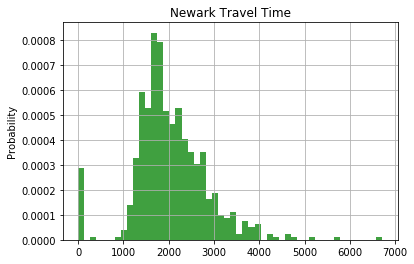

In [5]:
# Let's check airport trips for fare and duration 
fa = np.array(new_trips.trip_time_in_secs)
plt.hist(fa, bins=50, normed=True, facecolor='green', alpha=0.75)
plt.ylabel('Probability')
plt.title('Newark Travel Time')
plt.grid(True)
print("Standard Deviation of travel Time: {}".format(np.std(new_trips.trip_time_in_secs)))

In [6]:
#Importing zones to check how many trips done from/to manhattan
zones = process_zones('./data/taxi_zones/taxi_zones.json')

In [7]:
#Let's see how many trips are from manhattan
s = time.time()
manhattan = []
for z in zones:
    if z.boro == "Manhattan":
        manhattan.append(z.locID)
manhattan_mapper = {}
manhattan_pickups_mapper = {}

for index, row in merged.iterrows():
    ids = row['id']
    ploc = row['pick_locid']
    dloc = row['drop_locid']
    if ploc in manhattan or dloc in manhattan:
        manhattan_mapper.update({ids: 1})
    else:
        manhattan_mapper.update({ids: 0})
    if ploc in manhattan:
        manhattan_pickups_mapper.update({ids: 1})
    else:
        manhattan_pickups_mapper.update({ids: 0})

col1 = 'in_manhattan'
col2 = 'pickup_in_manhattan'
merged = merged.assign(**{col1:np.full(len(merged.index), int(-2))})
merged = merged.assign(**{col2:np.full(len(merged.index), int(-2))})
merged[col1] = merged['id'].map(manhattan_mapper)
merged[col2] = merged['id'].map(manhattan_pickups_mapper)

manh_trips = merged[merged.in_manhattan == 1]
manh_picks = merged[merged.pickup_in_manhattan == 1]

e = time.time()
print("Time: {} ".format(e-s))
print("Manhattan Trips: {}".format(len(manh_trips.index) / len(merged.index)))
print("Manhattan Pickups: {}".format(len(manh_picks.index) / len(merged.index)))

Time: 28.041457891464233 
Manhattan Trips: 0.9638229961256799
Manhattan Pickups: 0.9245679211759005


In [8]:
#Lets find most busiest suburbs in terms of pickups
start = time.time()
print(len(merged.index))
for index, row in merged.iterrows():
    ploc = row['pick_locid']
    idx = ploc - 1 
    if idx > 0 and idx < 399:
        zones[idx].count += 1
end = time.time()
zsorted = sorted(zones, key=attrgetter('count'), reverse=True)
print("Busiest parts of the city:")
for j in range(int(100)):
    print("Area: '{}' ; Pickups: {}; Percent: {}".format(zsorted[j].name, zsorted[j].count, zsorted[j].count / len(merged.index)))
print("done in {}".format(end - start))

439561
Area: 'Upper East Side South' ; Pickups: 16770; Percent: 0.03815170135658077
Area: 'Midtown Center' ; Pickups: 15580; Percent: 0.03544445480832012
Area: 'Midtown East' ; Pickups: 15085; Percent: 0.03431833124412766
Area: 'Upper East Side North' ; Pickups: 15077; Percent: 0.03430013126733263
Area: 'Murray Hill' ; Pickups: 15035; Percent: 0.03420458138915873
Area: 'Union Sq' ; Pickups: 14871; Percent: 0.033831481864860624
Area: 'Times Sq/Theatre District' ; Pickups: 14500; Percent: 0.03298745794099112
Area: 'East Village' ; Pickups: 14313; Percent: 0.03256203348340731
Area: 'Clinton East' ; Pickups: 13883; Percent: 0.03158378473067447
Area: 'Penn Station/Madison Sq West' ; Pickups: 12798; Percent: 0.029115412877848582
Area: 'Lincoln Square East' ; Pickups: 12368; Percent: 0.02813716412511574
Area: 'Gramercy' ; Pickups: 12057; Percent: 0.027429640027208966
Area: 'Midtown North' ; Pickups: 11312; Percent: 0.025734767188171834
Area: 'East Chelsea' ; Pickups: 11261; Percent: 0.0256187